In [1]:
### This will simulate a two state ising model on a square lattice.
### This is version_1.


import numpy as np
import matplotlib.pyplot as plt
from numpy import random 

from celluloid import Camera

### The Ising Hamiltonian:
Given small magnets held onto a lattice, $s_i = \pm 1$ is the state of $i^{th}$ magnet. The +1 state is called spin up and -1 is called spin-down. This can be thought of as North pole up or North pole down. We also further assume that these magnets are restructed to be either up or down and nothing in between. $J_{ij}$ is the interaction between spin 'i' and spin 'j'. And Finally, the second term is the interaction of any spin with the external magnetic field $h$. Since this is a magnetic field, it can have different values at different sites. The spin at site 'i'- $s_i$ only interacts with magnetic field's value at site i - $h_i$. The Hamiltonian is then,

$$ E  = -\sum_{ij}J_{ij} s_i s_j + \sum_{i}h_i s_i$$

#### Generating Lattice and Calculating the energy:
Suppose we assume the space where the spins are held in place to be a square lattice. For now, let us also assume that any spins interacts with all of its neighbors. 

In [7]:
def Random_State_Ising(N_latt):

    """ Given the width of the lattice - N_latt,
        this function initializes a Random state of spins in a N_latt X N_latt grid.
        
        - Output = N_latt X N_latt matrix with randomly placed +1 and -1. """
    
    State  =  np.random.choice([-1,1],(N_latt, N_latt))
    return State

In [8]:
## we will first start with the connectivity matrix.
## This tells us which spins interact with which spins.
## Not the magnitude of interaction- just the connection.
## Multiplication of connectivity with Energy magnitude T_{ij} gives the energy

def Connectivity_matrix_all_to_all(N_latt):
    ## We can represent the connectivity as a graph of N_latt**2 X N_latt**2 symmetric matrix.
    ## Each row i gives how spin s_i is connected to all other spins. 
    ## Connection of s_i with itself is zero.
    ## Connection of s_i with any other spin is 1
    dim_connectivity = N_latt**2
    Connectivity = np.ones((dim_connectivity , dim_connectivity)) - np.diag(np.ones(dim_connectivity))
    return Connectivity


def Energy_spin_spin_interaction(State, J_ij, Connectivity):
    """The energy contribution to spin-spin interaction alone:
    Inputs:
    - State (N_Latt X N_Latt image)
    - The interaction strength J_{ij}
    - The connectivity matrix
    """

    Weight_of_interaction = J_ij * Connectivity
    State_vector = State.reshape(np.size(State))   ### Converts the square image to an unfurled vector
    Energy = -1*(State_vector.T) @Weight_of_interaction @ State_vector

    return Energy


## 
def Energy_Ext_field (State,External_field= None):

    """This is the energy contribution due to external magnetic field.
    Inputs:
    - State (N_Latt X N_Latt image)
    - Magnetic field profile (N_Latt X N_Latt)"""
    Energy =0
    if External_field.all!=None:
        N_latt = np.size(State)
        Ext_field_vct = External_field.reshape(N_latt)
        State_vct = State.reshape(N_latt)
        Energy = np.dot(Ext_field_vct, State_vct)

    return Energy




def Total_Energy(State, J_ij, Connectivity, External_field =None):

    """This sums the spin-spin energy and the energy due to external magnetic field
    - State (N_Latt X N_Latt image)
    - The interaction strength J_{ij}
    - The connectivity matrix
    - Magnetic field profile (N_Latt X N_Latt) - (default None)
    - If Magnetic field profile not specified, this assumes absence of magnetic field
    """
    
    Spin_spin_interaction_energy = Energy_spin_spin_interaction(State, J_ij,Connectivity)

    External_field_interaction_energy = Energy_Ext_field(State, External_field)

    Total_Energy = Spin_spin_interaction_energy +External_field_interaction_energy

    return Total_Energy

In [9]:
def Monte_Carlo_Evolution(Num_iterations, State, J_ij, Connectivity, External_field = None, Inverse_Temperature =1):

    State_array = [State.reshape(np.size(State))]

    Energy_array = [Total_Energy(State, J_ij, Connectivity,External_field)]
    #Magnetic_energy =[Ext_field_energy(Random_state_begin, External_field)]

    for t in range(0, Num_iterations-1):
        ### Measure (or in this case remember) the current state and its energy
        State_t = State_array[t]

        Energy_t = Energy_array[t]
        #Mag_energy_t = Magnetic_energy[t]

        ### Pick a single spin in this state.
        index_random = np.random.choice(range(0,len(State_t)),1)

        ## Then propose a flip of the spin
        Proposed_State = State_t.copy()
        Proposed_State[index_random] = State_t[index_random] * -1      ## if -1 then this becomes +1, if +1, this becomes -1

        ## Compute the energy of this new state
        Energy_of_proposed_state = Total_Energy(Proposed_State,J_ij, Connectivity, External_field)

        #Magnetic_energy_of_proposed_state = Ext_field_energy(Proposed_State, Mag_field)

        ## See if the energy drops with this edit.

        Delta_Energy = Energy_of_proposed_state - Energy_t

        ## Based on this, probabilistically choose to accept or reject it.
        Transition_probability =  np.exp(-1* Inverse_Temperature *Delta_Energy)

        ### Do we accept this or reject this? We need to draw from the probability above.

        Accept_reject = np.min((1, Transition_probability))

        if Accept_reject > np.random.uniform(0,1):
            ## Then we accept this proposition

            State_array.append(Proposed_State)
            Energy_array.append(Energy_of_proposed_state)
            #Magnetic_energy.append(Magnetic_energy_of_proposed_state)
        else:
            State_array.append(State_t)
            Energy_array.append(Energy_t)
            #Magnetic_energy.append(Mag_energy_t)

    return Energy_array, State_array  #, Magnetic_energy

In [18]:

N_lattice = 30

Random_state_begin = Random_State_Ising(N_lattice)
#Random_state_begin = np.ones((N_lattice, N_lattice))
Connectivity_matrix  = Connectivity_matrix_all_to_all(N_lattice)
J_ij = 1

External_magnetic_field = np.zeros(np.shape(Random_state_begin))

N_steps = 3000 * int(np.sqrt(N_lattice))



In [19]:
Energy_evol, State_evol = Monte_Carlo_Evolution(N_steps, Random_state_begin,J_ij, Connectivity_matrix,External_magnetic_field)

/var/folders/96/v4x7j7l958xbclr4s0d46zlw0000gn/T/ipykernel_29798/2803058470.py:32: RuntimeWarning: overflow encountered in exp
  Transition_probability =  np.exp(-1* Inverse_Temperature *Delta_Energy)


Text(0.5, 1.0, 'Final State')

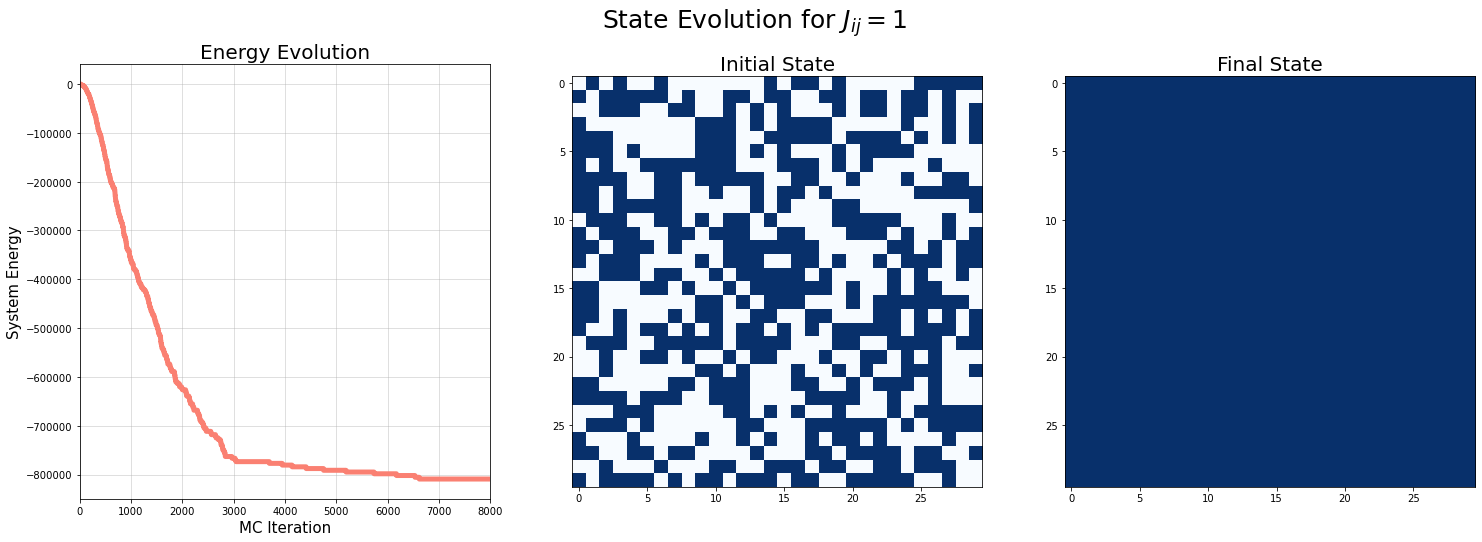

In [22]:
fig, ax = plt.subplots(1,3, figsize = (25,8))
plt.suptitle(r"State Evolution for $J_{ij}=$" + str(J_ij), fontsize = 25 )
ax[0].plot(range(0, N_steps),Energy_evol, color = "salmon", linewidth = 5)
ax[0].grid(alpha = 0.5, zorder = 0)
ax[0].set_xlim(0,8000)
ax[0].set_xlabel("MC Iteration", fontsize = 15)
ax[0].set_ylabel("System Energy", fontsize = 15)
ax[0].set_title("Energy Evolution", fontsize = 20)

ax[1].imshow(State_evol[0].reshape(N_lattice, N_lattice), cmap = "Blues", vmin =-1, vmax = 1)
ax[1].set_title("Initial State", fontsize =20)
ax[2].imshow(State_evol[-1].reshape(N_lattice, N_lattice), cmap = "Blues",vmin =-1, vmax = 1)
ax[2].set_title("Final State",fontsize = 20)



/opt/anaconda3/lib/python3.9/site-packages/matplotlib/animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


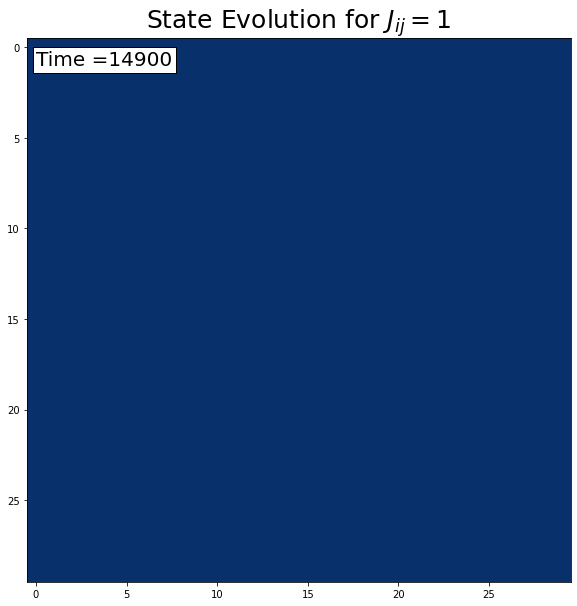

MovieWriter ffmpeg unavailable; using Pillow instead.


In [36]:
#Set Animate= True if you want to make a gif
Animate = False

Step =100    ### Save every frame after Step.

if Animate==True:
    Name = "Ising_j_ij_"+str(J_ij)+"_Lattice_size_"+str(N_lattice)+".gif"
    fig = plt.figure(figsize=(10,10))
    camera = Camera(fig)
    plt.title(r"State Evolution for $J_{ij}=$" + str(J_ij), fontsize = 25 )
    for i in range(0, N_steps,Step):
        state = State_evol[i].reshape(N_lattice, N_lattice)
        plt.imshow(state,cmap = "Blues", vmin = -1, vmax =1)   
        plt.text(s ="Time =" +str(i), x = 0, y = 1, color = "black",fontsize = 20,bbox=dict(facecolor='white', edgecolor='black', pad=3.50))
        camera.snap()
        animation = camera.animate()
    plt.show()
    animation.save(Name)

## Systems with Magnetic Field.

In this section, we will investigate what happens when we superimpose an external magnetic field.


Text(0.5, 1.0, 'Magnetic Field Configuration 2')

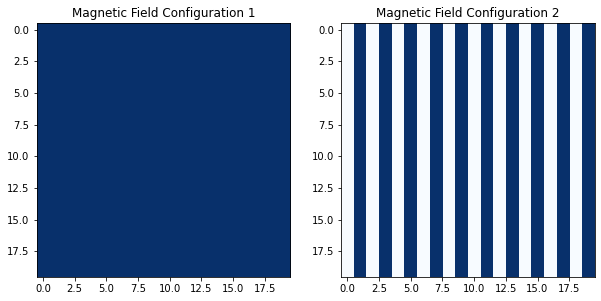

In [45]:

N_lattice = 20

Random_state_begin = Random_State_Ising(N_lattice)
#Random_state_begin = -1*np.ones((N_lattice, N_lattice))
Connectivity_matrix  = Connectivity_matrix_all_to_all(N_lattice)
J_ij = -1


### What happens if there is a magnetic field?

## Let us first create the magnetic field profile.
## We can choose any arrangement of numbers between 1 and -1.
## I will create two different magnetic fields.

#1. Constant magnetic field. 

H_field_0 = np.ones((N_lattice, N_lattice))     


#2. Alternating magnetic field
H_field_1 = np.ones((N_lattice, N_lattice))  

for i in range(0,N_lattice,2):
    H_field_1[:,i] = -1*np.ones(N_lattice)


fig, ax = plt.subplots(1,2 ,figsize=(10,5))
ax[0].imshow(H_field_0, cmap = "Blues", vmin = -1, vmax = 1)
ax[0].set_title("Magnetic Field Configuration 1")
ax[1].imshow(H_field_1, cmap = "Blues", vmin = -1, vmax = 1)
ax[1].set_title("Magnetic Field Configuration 2")



In [46]:
Magnitude_B = 2
External_Mag_field = -2.1*H_field_1

In [47]:
Energy_evol_mag, State_evol_mag = Monte_Carlo_Evolution(N_steps, Random_state_begin,J_ij, Connectivity_matrix,External_Mag_field)

Text(0.5, 1.0, 'Final State')

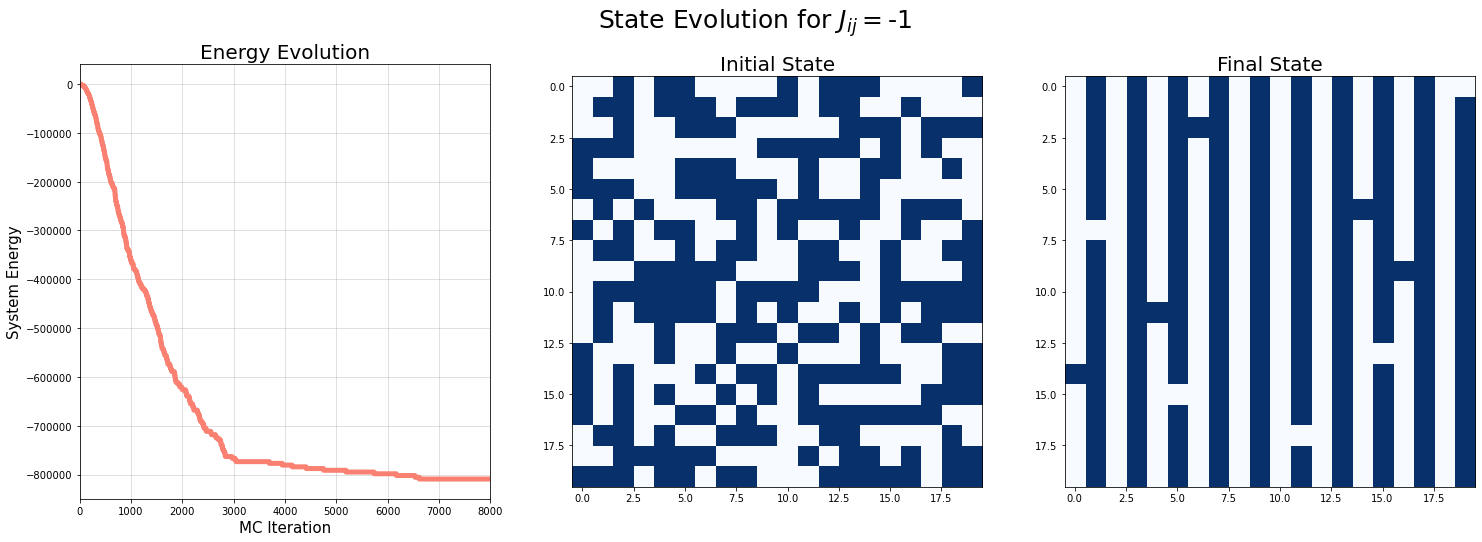

In [48]:
fig, ax = plt.subplots(1,3, figsize = (25,8))
plt.suptitle(r"State Evolution for $J_{ij}=$" + str(J_ij), fontsize = 25 )
ax[0].plot(range(0, N_steps),Energy_evol, color = "salmon", linewidth = 5)
ax[0].grid(alpha = 0.5, zorder = 0)
ax[0].set_xlim(0,8000)
ax[0].set_xlabel("MC Iteration", fontsize = 15)
ax[0].set_ylabel("System Energy", fontsize = 15)
ax[0].set_title("Energy Evolution", fontsize = 20)

ax[1].imshow(State_evol_mag[0].reshape(N_lattice, N_lattice), cmap = "Blues", vmin =-1, vmax = 1)
ax[1].set_title("Initial State", fontsize =20)
ax[2].imshow(State_evol_mag[-1].reshape(N_lattice, N_lattice), cmap = "Blues",vmin =-1, vmax = 1)
ax[2].set_title("Final State",fontsize = 20)


In [49]:
#Set Animate= True if you want to make a gif
Animate = False

Step =100    ### Save every frame after Step.

if Animate==True:
    Name = "Ising_with_Mag_field_j_ij_"+str(J_ij)+"_Lattice_size_"+str(N_lattice)+".gif"
    fig = plt.figure(figsize=(10,10))
    camera = Camera(fig)
    plt.title(r"State Evolution for $J_{ij}=$" + str(J_ij), fontsize = 25 )
    for i in range(0, N_steps,Step):
        state = State_evol_mag[i].reshape(N_lattice, N_lattice)
        plt.imshow(state,cmap = "Blues", vmin = -1, vmax =1)   
        plt.text(s ="Time =" +str(i), x = 0, y = 1, color = "black",fontsize = 20,bbox=dict(facecolor='white', edgecolor='black', pad=3.50))
        camera.snap()
        animation = camera.animate()
    plt.show()
    animation.save(Name)

## What happens if we only had the nearest neighbor interaction?
#### Every [i,j] point is connected only to the following neighbors.

            #              [i-1,j]
            #                 | 
            #    [i, j-1] --[i,j]--[i,j+1]
            #                 |
            #              [i+1,j]


#### You can enforce this by modifying the connectivity matrix such that only nearest neighbor's values are 1.

### Explore the relationship between Energy due to spin-spin interaction and Energy due to magnetic field.
### Is there a crossover when the interaction is solely due to one vs solely due to other?

